# Iterative lensing estimation demo (CMB-S4).

This notebook goes through an example of lensing iterative reconstruction, from polarization Q and U CMB data, with noise level of 2.12 $\mu$K-arcmin, on 650 square degrees, under ideal conditions (no masking, homogeneous noise, etc), with pixel size 1.5 arcmin. Specifically, we proceed as follows
1. We build the quadratic estimator and initial curvature estimates
2. We setup the iterator instance
3. We perform the iterations
4. We have a quick look at the quality of the lensing map reconstruction

It should take or minute or so to perform all iterations from the starting point.

Before starting, set the environment variable LENSIT to somewhere that is safe to write. A bunch of stuff might get cached.

In [1]:
%matplotlib inline
import lensit as li
import os

pbs.py : This looks like invocation on the laptop
pbs.py : setup OK, rank 0 in 1


### 1. We build the quadratic estimator and initial curvature estimates:

In [2]:
def get_starting_point(idx): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 
    sims = li.get_maps_lib('S4', 10, 11) # Simulation-library for configuration 'S4'. 
                                         # Parameters 10, 11 produces data on 645 sq. deg, 
                                         # with lensed CMB's generated at 0.75 arcmin resolution, 
                                         # but data collected at 1.5 arcmin resolution. 
    
    isocov = li.get_isocov('S4', 10, 11) # Isotropic filtering instance, that can used for Q.E. calculation
                                         # and other things.isocov.lib_datalm defines the mode-filtering applied 
                                         # the data, and isocov.lib_skyalm the band-limits of the unlensed sky.
    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    
    lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    def cli(cl):
        ret = np.zeros_like(cl)
        ret[np.where(cl > 0)] = 1./cl[np.where(cl > 0)]
        return ret
    
    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    datalms = np.array([isocov.lib_datalm.map2alm(m) for m in sims.get_sim_qumap(idx)]) 
    H0len =  cli(isocov.get_N0cls('QU', lib_qlm, use_cls_len=True)[0])
    plm0 = 0.5 * isocov.get_qlms('QU',  isocov.get_iblms('QU', datalms, use_cls_len=True)[0], lib_qlm, 
                                 use_cls_len=True)[0]
    
    # Normalization and Wiener-filtering:
    cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]
    lib_qlm.almxfl(plm0, cli(H0len + cli(cpp_prior)), inplace=True)
    
    # Initial likelihood curvature guess. We use here N0 as calculated with unlensed CMB spectra:
    H0unl =  cli(isocov.get_N0cls('QU', lib_qlm, use_cls_len=False)[0])
    return plm0, lib_qlm, datalms, isocov.lib_datalm, H0unl

plm0, lib_qlm, datalms, lib_datalm, H0 = get_starting_point(0)

 I will be using data from ell=14 to ell=3000 only
 The sky band-limit is ell=6000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


### 2. We setup the iterator instance:

In [3]:
def get_itlib(lib_dir, plm0, lib_qlm,  datalms, lib_datalm, H0, beam_fwhmamin=3., NlevT_filt=1.5, NlevP_filt=1.5 * np.sqrt(2.)):
    """
    This returns an iterator instance from the input data maps, lensing map starting point,
    likelihood curvature guess and choice of filtering parameters (ideally close to those of the data).
    """
    if not os.path.exists(lib_dir): 
        os.makedirs(lib_dir)
    # Prior on lensing power spectrum, and CMB spectra for the filtering at each iteration step.
    cls_unl = li.get_fidcls(6000)[0]
    cpp_prior = cls_unl['pp'][:]
    
    
    lib_skyalm = li.ffs_covs.ell_mat.ffs_alm_pyFFTW(lib_datalm.ell_mat, filt_func=lambda ell:ell<=6000)
                            #: This means we perform here the lensing of CMB skies at the same resolution 
                            #  than the data with the band-limit of 6000.
    transf = hp.gauss_beam(beam_fwhmamin / 180. / 60. * np.pi, lmax=6000) #: fiducial beam
    
    # Anisotropic filtering instance, with unlensed CMB spectra as inputs. Delfections will be added by the iterator.
    filt = li.qcinv.ffs_ninv_filt_ideal.ffs_ninv_filt(lib_datalm, lib_skyalm, cls_unl, transf, NlevT_filt,NlevP_filt)
    
    # Description of the multi-grid chain to use: (here the simplest, diagonal pre-conditioner) 
    chain_descr = li.qcinv.chain_samples.get_isomgchain(filt.lib_skyalm.ellmax,filt.lib_datalm.shape,
                                                        tol=1e-6,iter_max=200)
    
    # We assume no primordial B-modes, the E-B filtering will assume all B-modes are either noise or lensing:
    opfilt =  li.qcinv.opfilt_cinv_noBB
    opfilt._type = 'QU' # We consider polarization only
    
    # With all this now in place, we can build the iterator instance:
    iterator = li.ffs_iterators.ffs_iterator.ffs_iterator_pertMF(lib_dir, 'QU', filt, datalms, lib_qlm, 
              plm0, H0, cpp_prior, chain_descr=chain_descr, opfilt=opfilt, verbose=True)
               # We use here an iterator instance that uses an analytical approximation 
               # for the mean-field term at each step.
    return iterator


lib_dir = os.path.join(os.environ['LENSIT'], 'temp', 'iterator_S4_sim%03d'%0)
itlib = get_itlib(lib_dir, plm0, lib_qlm, datalms, lib_datalm, H0)

 I see t 1.5
 I see q 2.121320343559643
 I see u 2.121320343559643
ffs iterator : This is 0 trying to setup /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000
++ ffs_QU_iterator: Caching qlm_norms and N0s /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000
     cached /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_P_H0.dat
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/Phi_plm_it000.npy
++ ffs_QU masked iterator : setup OK


### 3. We perform the iterations:
This should take about ~ 1 min. to finish. A lot of print-out in verbose mode.

In [4]:
itlib.soltn_cond = True
for i in range(10):
    itlib.iterate(i, 'p')

rank 0 caching displacement comp. for it. 0 for key p
rank 0, ffs_deflect::buffers size, chk_shape (18, 22) [1024 1024]
rank 0 inverting displacement it. 0 for key p
 [00:00:01] ffs_deflect::calculating inverse displ. field > 00%
rank 0, ffs_deflect::buffers size, chk_shape (18, 22) [1024 1024]
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPpri_it000.npy
     get_Pmatinv:: cached /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/isocov/QU_Pmatinv_unl_00.npy
     get_Pmatinv:: cached /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/isocov/QU_Pmatinv_unl_10.npy
     get_Pmatinv:: cached /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/isocov/QU_Pmatinv_unl_11.npy
Cached  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/isocov/QU_MFresplm_unl.npy
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPdet_it000.npy
rank 0, ffs_deflect::buffers size, chk_shape (18, 22) 

 [00:00:01] ffs_deflect::calculating inverse displ. field > 00%
rank 0, ffs_deflect::buffers size, chk_shape (19, 20) [1024 1024]
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPpri_it003.npy
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPdet_it003.npy
rank 0, ffs_deflect::buffers size, chk_shape (19, 20) [1024 1024]
rank 0, ffs_deflect::buffers size, chk_shape (19, 20) [1024 1024]
rank 0 loading  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/MAPlms/Mlik_p_it2.npy
This is calc prep for QU W. Filtering cinv_noBB
(1024, 6000) [00:00:00] (0, 0.0184406263)
(1024, 6000) [00:00:01] (1, 0.0016744824)
(1024, 6000) [00:00:01] (2, 0.0002433826)
(1024, 6000) [00:00:02] (3, 0.0000463322)
(1024, 6000) [00:00:02] (4, 0.0000103845)
(1024, 6000) [00:00:03] (5, 0.0000024999)
(1024, 6000) [00:00:04] (6, 0.0000005956)
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/MAPlms/Mlik_p_it

rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/Hessian/rlm_sn_5_p.npy
 [00:00:00]  Exec. time for descent direction calculation
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/Phi_plm_it006.npy
     removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/f_p_it005_dx.npy
     removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/f_p_it005_dy.npy
     removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/finv_p_it005_dx.npy
     removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/finv_p_it005_dy.npy
Removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/f_0005_libdir
Removed : /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/finv_0005_libdir
rank 0 caching displacement comp. for it. 6 for key p
rank 0, ffs_deflect::buffers size, chk_shape (20, 21) [1024 1024]
rank 0 inverting displacement it. 6 for key p
 [00:00:01] ffs_deflec

 [00:00:01] ffs_deflect::calculating inverse displ. field > 00%
rank 0, ffs_deflect::buffers size, chk_shape (20, 21) [1024 1024]
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPpri_it008.npy
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/qlm_gradPdet_it008.npy
rank 0, ffs_deflect::buffers size, chk_shape (20, 21) [1024 1024]
rank 0, ffs_deflect::buffers size, chk_shape (20, 21) [1024 1024]
rank 0 loading  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/MAPlms/Mlik_p_it7.npy
This is calc prep for QU W. Filtering cinv_noBB
(1024, 6000) [00:00:00] (0, 0.0016126164)
(1024, 6000) [00:00:01] (1, 0.0001550731)
(1024, 6000) [00:00:02] (2, 0.0000228909)
(1024, 6000) [00:00:02] (3, 0.0000044075)
(1024, 6000) [00:00:03] (4, 0.0000010293)
(1024, 6000) [00:00:03] (5, 0.0000002628)
rank 0 caching  /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/MAPlms/Mlik_p_it8.npy
rank 0, ffs_deflect::buffers size, c

### 4. We have a quick look at the quality of the lensing map reconstruction:
We plot the binned power spectrum of the residual map
$$
\hat \phi - \phi^{\rm input}
$$


[]

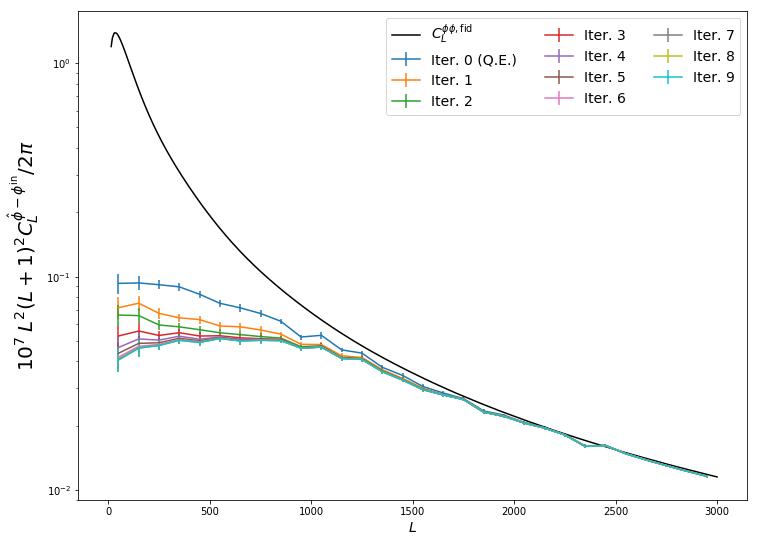

In [5]:
ell, = np.where(itlib.lib_qlm.get_Nell()[:3001])
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 /2./np.pi * 1e7
edges = np.arange(0, 3100, 100)
bl = edges[:-1];bu = edges[1:] 

sims = li.get_maps_lib('S4', 10, 11)
plm_input = itlib.lib_qlm.udgrade(sims.lencmbs.lib_skyalm, sims.lencmbs.get_sim_plm(0))
bnd_cl = lambda cl : li.misc.misc_utils.binned(cl, ell, bl, bu, w=w, return_err=True)
pl.figure(figsize= (12,9))
for it in range(10):
    cl, err = bnd_cl(itlib.lib_qlm.alm2cl(itlib.get_Plm(it, 'p') - plm_input)) 
    pl.errorbar(0.5 * bl + 0.5 * bu, cl, yerr=err, label='Iter. %s'%it + (it == 0) * ' (Q.E.)')
pl.plot(ell, li.get_fidcls()[0]['pp'][ell] * w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
pl.ylabel(r'$10^7\: L^2(L + 1)^2 C^{\hat \phi - \phi^{\rm in}}_L /2 \pi$', fontsize=20)
pl.xlabel(r'$L$', fontsize=14)
pl.legend(ncol=3, fontsize=14)
pl.semilogy()



### This file contains very crude information on the iterator work and likelihood gradient amplitudes:

In [6]:
cat /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/history_increment.txt

# Iteration step 
# Exec. time in sec.
# Increment norm (normalized to starting point displacement norm) 
# Total gradient norm  (all grad. norms normalized to initial total gradient norm)
# Quad. gradient norm
# Det. gradient norm
# Pri. gradient norm
# Newton step length
001 9.8 0.222442 1.000000 2.037891 0.002678 1.860847 0.500000000000 
002 6.7 0.077196 0.516405 1.960754 0.002690 1.880613 0.500000000000 
003 6.3 0.069645 0.279139 1.926790 0.002811 1.913821 0.500000000000 
004 6.3 0.046802 0.131238 1.913139 0.002896 1.931858 0.500000000000 
005 6.4 0.034635 0.075987 1.910570 0.002906 1.927999 0.500000000000 
006 6.6 0.026556 0.051186 1.910350 0.002901 1.919388 0.500000000000 
007 6.2 0.014059 0.031628 1.910155 0.002898 1.912211 0.500000000000 
008 6.3 0.007070 0.017267 1.909889 0.002898 1.909698 0.500000000000 
009 6.4 0.004781 0.009412 1.909787 0.002898 1.909947 0.500000000000 


### Lensing maps: 
we plot the deflection $\hat \alpha_{LM} = \sqrt{L (L + 1)} \hat \phi_{LM}$

(Text(0.5,1,u'$\\alpha^{\\rm input}$'), (-0.5, 1023.5, 1023.5, -0.5))

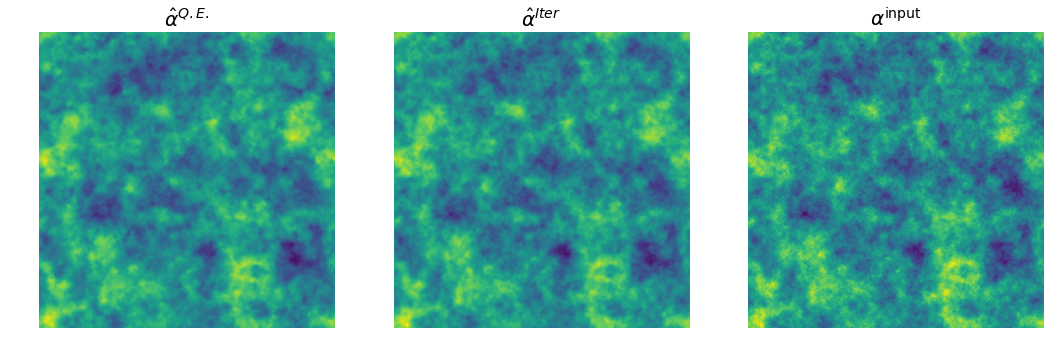

In [7]:
plm2alphalm = lambda plm : lib_qlm.almxfl(plm, np.arange(lib_qlm.ellmax + 1))
fig, ax = pl.subplots(1, 3, figsize=(18, 6),)
vmax = np.max(np.abs(lib_qlm.alm2map(plm2alphalm(plm_input))))
ax[0].imshow(lib_qlm.alm2map(plm2alphalm(itlib.get_Plm(0, 'p'))), vmax=vmax, vmin=-vmax)
ax[1].imshow(lib_qlm.alm2map(plm2alphalm(itlib.get_Plm(9, 'p'))), vmax=vmax, vmin=-vmax)
ax[2].imshow(lib_qlm.alm2map(plm2alphalm(plm_input)), vmax=vmax, vmin=-vmax)
ax[0].set_title(r'$\hat \alpha^{Q.E.}$', fontsize=20), ax[0].axis('off')
ax[1].set_title(r'$\hat \alpha^{Iter}$', fontsize=20), ax[1].axis('off')
ax[2].set_title(r'$\alpha^{\rm input}$', fontsize=20), ax[2].axis('off')